In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
path = 'panen1.xlsx'
well = pd.read_excel(path)
well

,depth,gr,porosity,density,p-wave,s-wave,resistivity
0,950.0616,91.977203,0.257198,2.39590,2649.033786,785.314915,2.137500
1,950.2140,92.350197,0.252759,2.38700,2618.090669,786.307694,2.141800
2,950.3664,91.907600,0.250220,2.37450,2638.050906,787.276994,2.111800
3,950.5188,91.033096,0.248467,2.35890,2668.932677,788.248687,2.112900
4,950.6712,90.985603,0.246784,2.34820,2620.314708,789.222781,2.143900
...,...,...,...,...,...,...,...
1309,1149.5532,55.820099,0.302397,2.09700,2648.662596,1256.274280,1.944900
1310,1149.7056,57.927601,0.284193,2.14370,2651.771126,1284.754154,1.874500
1311,1149.8580,66.371201,0.268855,2.18240,2645.626822,1305.585294,1.826400
1312,1150.0104,76.750801,0.258110,2.17890,2599.210175,1314.555822,1.820400


## 1. Plotting Sumur Panen-1

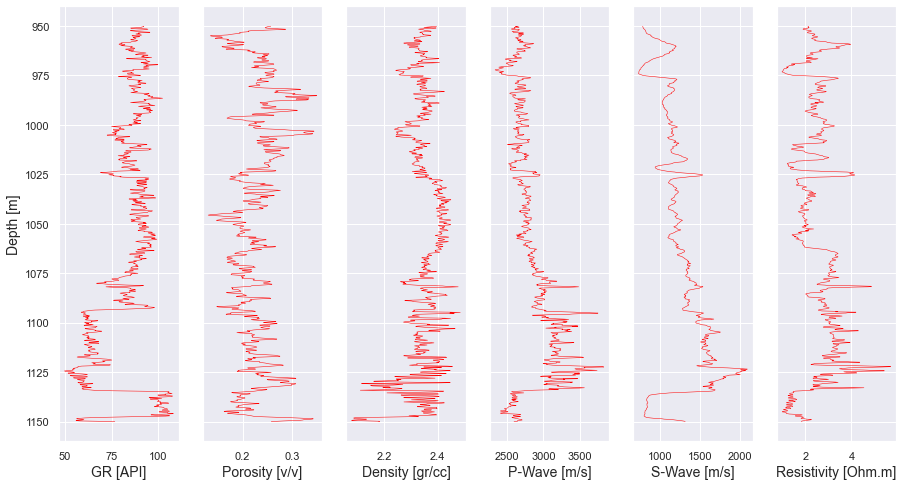

In [3]:
def plot_well():
    sns.set_theme()
    fig, ax = plt.subplots(1, 6, figsize=(15, 8), sharey=True)
    
    ax[0].plot(well['gr'], well['depth'], color='red', linewidth=0.5)
    ax[0].set_ylabel('Depth [m]', size=14)
    ax[0].set_xlabel('GR [API]', size=14)
    ax[0].invert_yaxis()
    ax[1].plot(well['porosity'], well['depth'], color='red', linewidth=0.5)
    ax[1].set_xlabel('Porosity [v/v]', size=14)
    ax[2].plot(well['density'], well['depth'], color='red', linewidth=0.5)
    ax[2].set_xlabel('Density [gr/cc]', size=14)
    ax[3].plot(well['p-wave'], well['depth'], color='red', linewidth=0.5)
    ax[3].set_xlabel('P-Wave [m/s]', size=14)
    ax[4].plot(well['s-wave'], well['depth'], color='red', linewidth=0.5)
    ax[4].set_xlabel('S-Wave [m/s]', size=14)
    ax[5].plot(well['resistivity'], well['depth'], color='red', linewidth=0.5)
    ax[5].set_xlabel('Resistivity [Ohm.m]', size=14)
    plt.savefig('well.png', dpi=120)
    plt.show()

plot_well()

## 2. Solid Rock Modelling

In [4]:
x = np.arange(0, 0.4, 0.01)

m1,b1 = np.polyfit(well['porosity'], well['p-wave'], 1)
m2,b2 = np.polyfit(well['porosity'], well['s-wave'], 1)
m3,b3 = np.polyfit(well['porosity'], well['density'], 1)

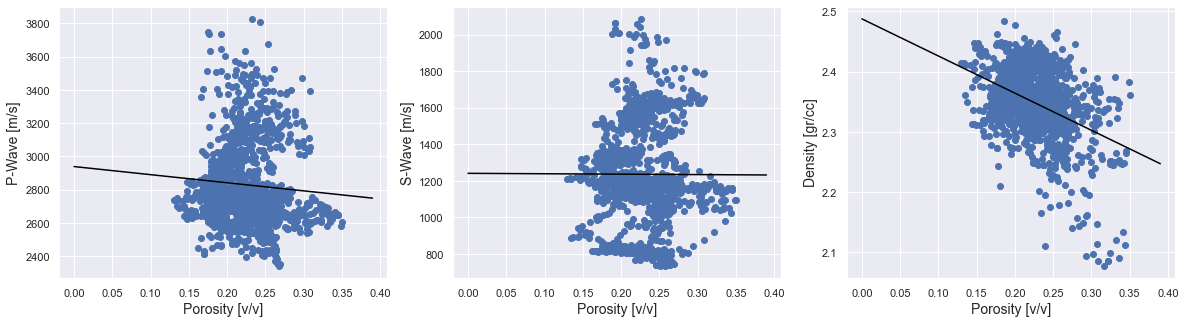

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(well['porosity'], well['p-wave'])
ax[0].plot(x, m1*x + b1, color='black')
ax[0].set_xlabel('Porosity [v/v]', size=14)
ax[0].set_ylabel('P-Wave [m/s]', size=14)

ax[1].scatter(well['porosity'], well['s-wave'])
ax[1].plot(x, m2*x + b2, color='black')
ax[1].set_xlabel('Porosity [v/v]', size=14)
ax[1].set_ylabel('S-Wave [m/s]', size=14)

ax[2].scatter(well['porosity'], well['density'])
ax[2].plot(x, m3*x + b3, color='black')
ax[2].set_xlabel('Porosity [v/v]', size=14)
ax[2].set_ylabel('Density [gr/cc]', size=14)

plt.savefig('regresi.png', dpi=120)
plt.show()

In [6]:
print('P-Wave Solid -->', b1, 'm/s')
print('S-Wave Solid -->', b2, 'm/s')
print('Density Solid -->', b3, 'gr/cc')

def bulk(vp, mu, rho):
    k = vp**2 * rho - (4/3)*mu

    return k

def shear(vs, rho):
    mu = vs**2*rho
    
    return mu


well['shear_sat'] = shear(well['s-wave']*1e-3, well['density'])
well['bulk_sat'] = bulk(well['p-wave']*1e-3, well['shear_sat'], well['density'])


vp = b1
vs = b2
rho = b3*1000

mu_m = shear(vs, rho)*1e-9
km = bulk(vp, mu_m, rho)*1e-9

print('Bulk Solid -->', km, 'GPa')
print('Shear Solid -->', mu_m, 'GPa')

P-Wave Solid --> 2938.7795228739305 m/s
S-Wave Solid --> 1241.0613532572756 m/s
Density Solid --> 2.487632974452047 gr/cc
Bulk Solid --> 21.484255815391514 GPa
Shear Solid --> 3.831535102016863 GPa


In [7]:
def p_wave(k, mu, rho):
    vp = np.sqrt( (k + (4/3)*mu) / rho )

    return vp

def s_wave(mu, rho):
    vs = np.sqrt(mu / rho)

    return vs

def k_hs(k1, f1, k2, f2, mu1):
    a = 1 / (k2 - k1)
    b = f1 / (k1 + (4/3)*mu1)
    k = k1 + f2/(a + b) 

    return k

def mu_hs(k1, mu1, mu2, f1, f2):
    a = 1 / (mu2 - mu1)
    b = 2*f1*(k1 + 2*mu1)/ ( 5*mu1*(k1 + (4/3)*mu1))
    mu = mu1 + f2/(a + b)

    return mu

In [8]:
km = 21
mum = 3.83
rhom = 2.48
rhooi = 0.7
koi = 0.6

phi = np.arange(0, 0.4, 0.01)
rho_sat = (1-phi)*rhom + phi*rhooi

#voigt
kv = km*(1 - phi) + phi*koi
muv = mum*(1 - phi)

#reuss
kr = 1 / ( (1 - phi)/km + phi / koi)
mur = 1 / ( (1 - phi)/mum)

#hill
kh = 0.5*(kv + kr)
muh = 0.5*(muv + mur)

vp_v = p_wave(kv, muv, rho_sat)
vp_r = p_wave(kr, mur, rho_sat)
vp_vrh = p_wave(kh, muh, rho_sat)

In [9]:
#upperbound hs
k1 = km
k2 = koi
f1 = 1-phi
f2 = phi

mu1 = mum
mu2 = 0.0001

k_uhs = k_hs(k1, f1, k2, f2, mu1)
mu_uhs = mu_hs(k1, mu1, mu2, f1, f2)

vp_uhs = p_wave(k_uhs, mu_uhs, rho_sat)
vs_uhs = s_wave(mu_uhs, rho_sat)

#lower bound
k1 = koi
k2 = km
f1 = phi
f2 = (1 - phi)

mu1 = 0.00001
mu2 = mum

k_lhs = k_hs(k1, f1, k2, f2, mu1)
mu_lhs = mu_hs(k1, mu1, mu2, f1, f2)

vp_lhs = p_wave(k_lhs, mu_lhs, rho_sat)
vs_lhs = s_wave(mu_lhs, rho_sat)

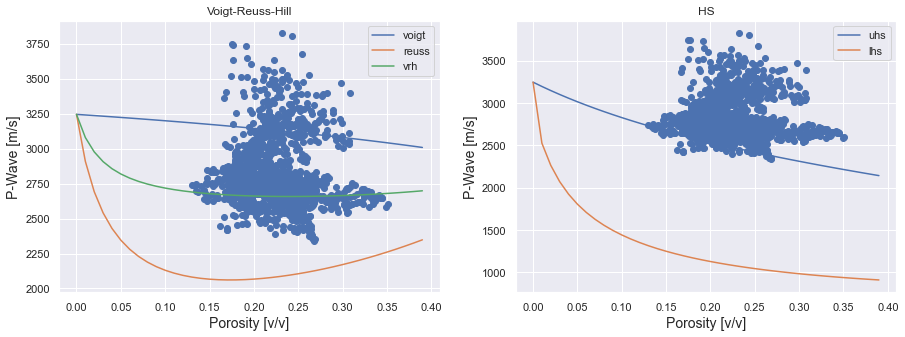

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(phi, vp_v*1000, label='voigt')
ax[0].plot(phi, vp_r*1000, label='reuss')
ax[0].plot(phi, vp_vrh*1000, label='vrh')
ax[0].set_title('Voigt-Reuss-Hill')
ax[0].set_ylabel('P-Wave [m/s]', size=14)
ax[0].set_xlabel('Porosity [v/v]', size=14)
ax[0].scatter(well['porosity'], well['p-wave'])
ax[0].legend()

ax[1].plot(phi, vp_uhs*1000, label='uhs')
ax[1].plot(phi, vp_lhs*1000, label='lhs')
ax[1].scatter(well['porosity'], well['p-wave'])
ax[1].set_ylabel('P-Wave [m/s]', size=14)
ax[1].set_xlabel('Porosity [v/v]', size=14)
ax[1].set_title('HS')
ax[1].legend()

plt.savefig('vrh_hs.png', dpi=120)
plt.show()

In [11]:
#voigt
kv = km*(1 - well['porosity']) + well['porosity']*koi
muv = mum*(1 - well['porosity'])

#reuss
kr = 1 / ( (1 - well['porosity'])/km + well['porosity'] / koi)
mur = 1 / ( (1 - well['porosity'])/mum)

#hill
kh = 0.5*(kv + kr)
muh = 0.5*(muv + mur)

well['bulk_hill'] = kh
well['shear_hill'] = muh

## 3. Dry Rock -- Inverse Gassmann

In [12]:
def K_dry(Ks, Km, Kf, phi):
    '''
    Gassmaan Fluid Replacement Modelling(FRM) menghitung modulus bulk dry berdasarkan modulus
    bulk saturasi.
    Argumens:
    Kd : modulus bulk dry
    Km : modulus bulk matrik
    Kf : modulus bulk fluida
    phi : porositas
    return:
    Modulus bulk dry
    '''
    gamma = phi*(Km/Kf - 1.0)
    return (Ks*(gamma + 1.0) - Km)/(gamma - 1.0 + Ks/Km)

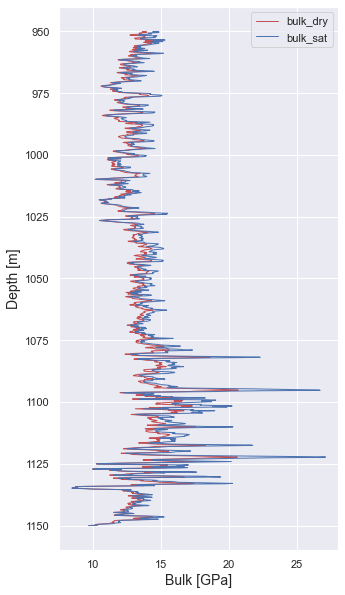

In [13]:
well['bulk_dry'] =K_dry(well['bulk_sat'], well['bulk_hill'], koi, well['porosity'])
well['density_dry'] = well['density'] - well['porosity']*rhooi
well['p-wave_dry'] = np.sqrt((well['bulk_dry'] + (4/3)*well['shear_sat']) / well['density_dry'])

plt.figure(figsize=(5, 10))
plt.plot(well['bulk_dry'], well['depth'], color='r', linewidth=1, label='bulk_dry')
plt.plot(well['bulk_sat'], well['depth'], color='b', linewidth=1, label='bulk_sat')
plt.ylabel('Depth [m]', size=14)
plt.xlabel('Bulk [GPa]', size=14)
plt.gca().invert_yaxis()

plt.legend()
plt.savefig('gasmaan.png', dpi=120)
plt.show()

### 4. Rock Physics Modelling - Diagenesa Modell

In [14]:
## Pressure
well['depth']
well['density']

p = 0
for i in range(len(well['depth']) - 1):
    if i == 0:
        t = well['depth'][i] - 0
    else:
        t = well['depth'][i] - well['depth'][i-1]
    
    p = p + well['density'][i]*1000*t*9.8

In [15]:
def hertzmindlin(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Hertz-Mindlin model

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    P /= 1e3  # converts pressure in same units as solid moduli (GPa)
    PR0 = (3*K0-2*G0)/(6*K0+2*G0)  # poisson's ratio of mineral mixture
    # print(PR0)
    K_HM = (P*(Cn**2*(1-phic)**2*G0**2) / (18*np.pi**2*(1-PR0)**2))**(1/3)
    G_HM = ((2+3*f-PR0*(1+3*f))/(5*(2-PR0))) * \
        ((P*(3*Cn**2*(1-phic)**2*G0**2)/(2*np.pi**2*(1-PR0)**2)))**(1/3)
    return K_HM, G_HM

# 1. Friable sand

def softsand_lower(K0, G0, phi, phic=0.4, Cn=8.6, P=18, f=1,kfl=0.06, rhob=2.65, rhob_fl=0.2):
    '''
    Soft-sand (uncemented) model

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination number (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    K_HM, G_HM = hertzmindlin(K0, G0, phi, phic, Cn, P, f)
    # G_HM = 0.5*G_HM
    K_DRY = -4/3*G_HM + (((phi/phic)/(K_HM+4/3*G_HM)) +
                         ((1-phi/phic)/(K0+4/3*G_HM)))**-1
    tmp = G_HM/6*((9*K_HM+8*G_HM) / (K_HM+2*G_HM))
    G_DRY = -tmp + ((phi/phic)/(G_HM+tmp) + ((1-phi/phic)/(G0+tmp)))**-1
    
    #Densitas Saturasi
    rhob_dry = (1-phi)*rhob
    
    #Biot Gassman
    Ksat = np.zeros((len(phi)))
#     for i in range(len(phi)):
#         Ksat[i] = K_DRY[i]  + ((((1-K_DRY[i]/K0))**2)/((phi[i]/kfl + ((1-phi[i])/K0)-(K_DRY[i]/(K0**2)))))
#         Ksat[i] = np.float(Ksat[i])
    Ksat = K_DRY
        
    vs = np.sqrt(G_DRY/rhob_dry)
    vp = np.sqrt((Ksat + 4/3*G_DRY)/rhob_dry)

    return Ksat, G_DRY, np.round(vp,3), vs


def softsand_upper(K0, G0, phi, phic=0.4, Cn=8.6, P=10):
    '''
    Soft-sand (uncemented) model

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination number (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    K_DRY = -4/3*G0 + (((phi/phic)/(K0+4/3*G0)) +
                       ((1-phi/phic)/(K0+4/3*G0)))**-1
    tmp = G0/6*((9*K0+8*G0) / (K0+2*G0))
    G_DRY = -tmp + ((phi/phic)/(G0+tmp) + ((1-phi/phic)/(G0+tmp)))**-1
    return K_DRY, G_DRY

# 2.Pemodelan Kontak Sementasi


def contactcement(K0, G0, phi, phic=0.4, Cn=8.6, Kc=37, kfl=0.06, Gc=45, rhob=2.65, rhob_fl=0.2, scheme=2):
    '''

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    Kc, Gc: cement bulk & shear modulus in GPa
            (default 37, 45 i.e. quartz)
    scheme: 1=cement deposited at grain contacts
            2=uniform layer around grains (default)
    '''
    PR0 = (3*K0-2*G0)/(6*K0+2*G0)
    PRc = (3*Kc-2*Gc)/(6*Kc+2*Gc)

    if scheme == 1:  # scheme 1: cement deposited at grain contacts
        alpha = ((phic-phi)/(3*Cn*(1-phic))) ** (1/4)
    else:  # scheme 2: cement evenly deposited on grain surface
        alpha = ((2*(phic-phi))/(3*(1-phic)))**(1/2)
    LambdaN = (2*Gc*(1-PR0)*(1-PRc)) / (np.pi*G0*(1-2*PRc))
    N1 = -0.024153*LambdaN**-1.3646
    N2 = 0.20405*LambdaN**-0.89008
    N3 = 0.00024649*LambdaN**-1.9864
    Sn = N1*alpha**2 + N2*alpha + N3
    LambdaT = Gc/(np.pi*G0)
    T1 = -10**-2*(2.26*PR0**2+2.07*PR0+2.3) * \
        LambdaT**(0.079*PR0**2+0.1754*PR0-1.342)
    T2 = (0.0573*PR0**2+0.0937*PR0+0.202) * \
        LambdaT**(0.0274*PR0**2+0.0529*PR0-0.8765)
    T3 = 10**-4*(9.654*PR0**2+4.945*PR0+3.1) * \
        LambdaT**(0.01867*PR0**2+0.4011*PR0-1.8186)
    St = T1*alpha**2 + T2*alpha + T3
    K_DRY = 1/6*Cn*(1-phic)*(Kc+(4/3)*Gc)*Sn
    G_DRY = 3/5*K_DRY+3/20*Cn*(1-phic)*Gc*St
    
    #Biot-Gassman
    Ksat = np.zeros((len(phi)))
#     for i in range(len(phi)):
#         Ksat[i] = K_DRY[i]  + ((((1-K_DRY[i]/K0))**2)/((phi[i]/kfl + ((1-phi[i])/K0)-(K_DRY[i]/(K0**2)))))
#         Ksat[i] = np.float(Ksat[i])
    Ksat = K_DRY
        
    M = Ksat + (4/3)*G_DRY
    result = dict(zip(list(phi), (zip(list(M), list(Ksat), list(G_DRY)))))
#     rhob_sat = (1-phi)*rhob + phi*rhob_fl
    rho_dry = (1-phi)*rhob
    vp = np.sqrt((Ksat + 4/3*G_DRY)/rho_dry)
    vs = np.sqrt(G_DRY/rho_dry)
    
    return result, M, Ksat, G_DRY, np.round(vp,3), vs

#3. Constant Cement
def constancement(Kb, Gb, Km, Gm, phi, phi_b=0.4,kfl=0.06, rhob=2.65, Cn=8.6, rhob_fl=0.8):
    '''
    Soft-sand (uncemented) model

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phi_b: critical porosity (default 0.4)
    Cn: coordination number (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    K_DRY = -4/3*Gb + (((phi/phi_b)/(Kb+4/3*Gb)) +
                       ((1-phi/phi_b)/(Km+4/3*Gb)))**-1
    tmp = Gb/6*((9*Kb+8*Gb) / (Kb+2*Gb))
    G_DRY = -tmp + ((phi/phi_b)/(Gb+tmp) + ((1-phi/phi_b)/(Gm+tmp)))**-1
    rhob_sat = (1-phi)*rhob
    
    #Biot Gassman
#     Ksat = np.zeros((len(phi)))
#     for i in range(len(phi)):
#         Ksat[i] = K_DRY[i]  + ((((1-K_DRY[i]/K0))**2)/((phi[i]/kfl + ((1-phi[i])/K0)-(K_DRY[i]/(K0**2)))))
#         Ksat[i] = np.float(Ksat[i])
    Ksat = K_DRY
    vp = np.sqrt((Ksat + 4/3*G_DRY)/rhob_sat)
    vs = np.sqrt(G_DRY/rhob_sat)
    return np.round(Ksat,3), np.round(G_DRY), np.round(vp,3), np.round(vs,3)

def porositas(init_poro, fin_poro, intv=0.001, digit=4):
        phi_co = []
        a = init_poro
        while(a <= fin_poro):
            phi_co.append(a)
            a = np.round((a+intv), digit)
        phi_co = np.array(phi_co)
        return phi_co

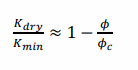

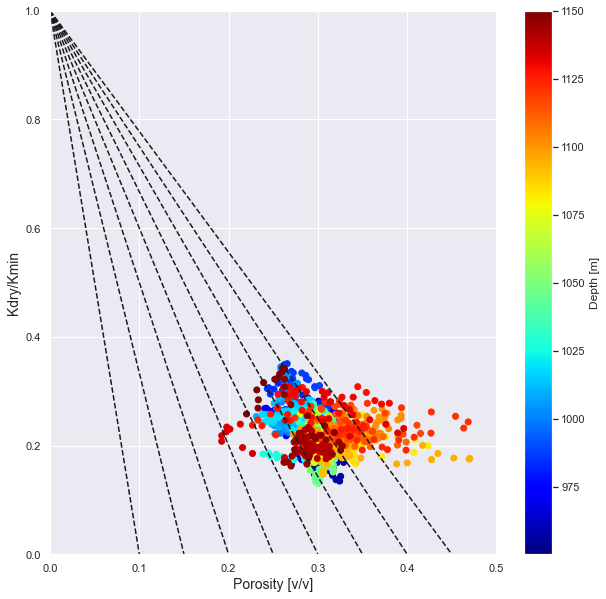

In [16]:
poro = np.arange(0, 0.5, 0.01)
poro_cri = np.arange(0.1, 0.5, 0.05)

y = []
for pc in poro_cri:
    y_tmp = 1 - poro/pc
    y.append(y_tmp)
    
plt.figure(figsize=(10, 10))
for yy in y: 
    plt.plot(poro, yy, color='k', linestyle='--')

plt.scatter(well['bulk_dry'] /44 , well['porosity'], c=well['depth'], cmap = 'jet')
plt.colorbar(label='Depth [m]')


plt.xlabel('Porosity [v/v]', size=14)
plt.ylabel('Kdry/Kmin', size=14)
plt.ylim(0, 1)
plt.xlim(0, 0.5)
plt.savefig('poro_crit.png', dpi=120)
plt.show()
# print(well['bulk_dry'] / well['bulk_hill'])

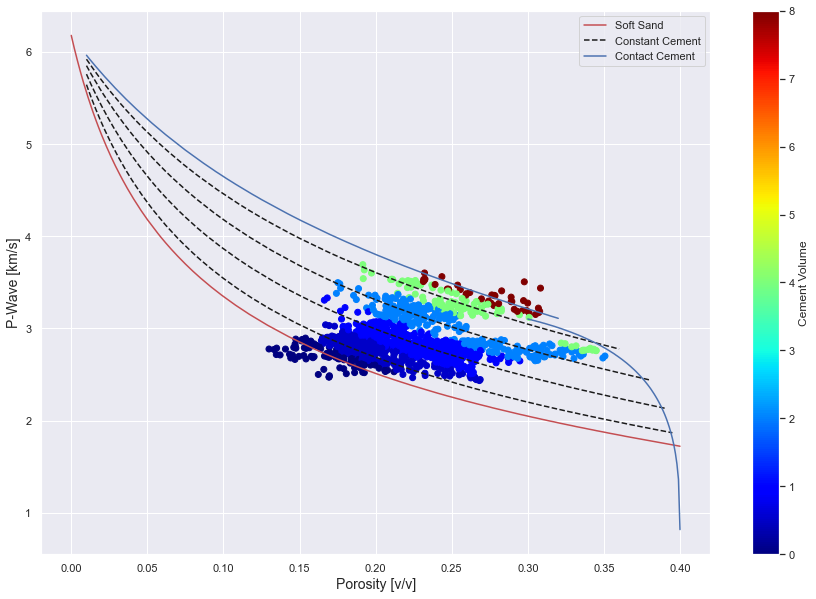

In [30]:
RHO_sh = 2.8
K_sh = 15
MU_sh = 5

phic = 0.4
f = 1

phi = np.arange(0, 0.401, 0.001)
K0, G0, RHO0 = 36, 44, 2.65

Cn = 20-34*phic+14*phic**2

phi_co = porositas(0.3, 0.4)
phi_cons30 = porositas(0.01, 0.30)
phi_cons32 = porositas(0.01, 0.32)
phi_cons34 = porositas(0.01, 0.34)
phi_cons36 = porositas(0.01, 0.36)
phi_cons38 = porositas(0.01, 0.38)
phi_cons39 = porositas(0.01, 0.39)
phi_cons395 = porositas(0.01, 0.395)

# print(phi_cons32)
# 1. Contact-cement

result, M, K_DRY, G_DRY, vp2, vs2 = contactcement(
    K0, G0, phi_co, phic=0.40, Cn=Cn, Kc= K_sh, Gc=MU_sh, scheme=2, rhob=2.65)

phi_bn = [0.3, 0.320, 0.340, 0.360, 0.380, 0.390, 0.395]

M_b = []
K_bc = []
G_bc = []
for phib in phi_bn:
    if phib in result.keys():
        M_b.append(result[phib][0])
        K_bc.append(result[phib][1])
        G_bc.append(result[phib][2])

# 2. Softsand/Friable sand
K_DRYL, G_DRYL, vp1, vs1 = softsand_lower(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1, rhob=rhom)

# 3. Constant-cement
K_DRYS30, G_DRYS30, vps30, vss30 = constancement(
    K_bc[0], G_bc[0], K0, G0, phi_cons30, phi_b=0.30, rhob=rhom, Cn=8.6, rhob_fl=0.2)
# print(K_DRYS30)

K_DRYS32, G_DRYS32, vps32, vss32 = constancement(
    K_bc[1], G_bc[1], K0, G0, phi_cons32, phi_b=0.32, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS34, G_DRYS34, vps34, vss34 = constancement(
    K_bc[2], G_bc[2], K0, G0, phi_cons34, phi_b=0.34, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS36, G_DRYS36, vps36, vss36 = constancement(
    K_bc[3], G_bc[3], K0, G0, phi_cons36, phi_b=0.36, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS38, G_DRYS38, vps38, vss38 = constancement(
    K_bc[4], G_bc[4], K0, G0, phi_cons38, phi_b=0.38, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS39, G_DRYS39, vps39, vss39 = constancement(
    K_bc[5], G_bc[5], K0, G0, phi_cons39, phi_b=0.39, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS395, G_DRYS395, vps395, vss395 = constancement(
    K_bc[6], G_bc[6], K0, G0, phi_cons395, phi_b=0.395, rhob=rhom, Cn=8.6, rhob_fl=0.2)


plt.figure(figsize=(15, 10))
plt.plot(phi, vp1, color='r', label='Soft Sand' )
plt.plot(phi_cons32, vps32, color='b' )
# plt.plot(phi_cons30, vps30, color='k', linestyle = '--', label='Constant Cement')
# plt.plot(phi_cons34, vps34, color='k', linestyle = '--')
plt.plot(phi_cons36, vps36, color='k', linestyle = '--', label='Constant Cement')
plt.plot(phi_cons38, vps38, color='k', linestyle = '--')
plt.plot(phi_cons39, vps39, color='k', linestyle = '--')
plt.plot(phi_cons395, vps395, color='k', linestyle = '--')

phi_model = np.hstack((phi, phi_cons395, phi_cons39, phi_cons38, phi_cons36, phi_cons32))
vp_model = np.hstack((vp1, vps395, vps39, vps38, vps36, vps32))
cement_model = np.hstack(( np.zeros(len(vp1)), np.zeros(len(vps395))+ 0.5, np.zeros(len(vps39))+1, np.zeros(len(vps38))+2,
                         np.zeros(len(vps36))+4, np.zeros(len(vps32))+8))

porositas_end = np.hstack(( np.zeros(len(vp1))+0.4, np.zeros(len(vps395))+ 0.395, np.zeros(len(vps39))+0.39, np.zeros(len(vps38))+0.38,
                         np.zeros(len(vps36))+0.36, np.zeros(len(vps32))+0.32))


list_cement = []
list_phi = []
for phi_w, vp_w in zip(well['porosity'], well['p-wave_dry']):
    r_tmp = np.inf
    cement = None
    phi_end = None
    
    for phi_m, vp_m, c, pe in zip(phi_model, vp_model, cement_model, porositas_end):
        r = np.sqrt( (phi_w - phi_m)**2 + (vp_w - vp_m)**2)
        if r < r_tmp:
            r_tmp = r
            cement = c
            phi_end = pe
            
    list_cement.append(cement)
    list_phi.append(phi_end)

well['cement'] = list_cement
well['porositas_end'] = list_phi

plt.scatter(well['porosity'], well['p-wave_dry'], c=well['cement'], cmap='jet')
plt.colorbar(label='Cement Volume')
plt.xlabel('Porosity [v/v]', size=14)
plt.ylabel('P-Wave [km/s]', size=14)
plt.plot(phi_co, vp2, label='Contact Cement', color='b')
plt.legend()
plt.plot()
plt.savefig('cement.png', dpi=120)
plt.show()

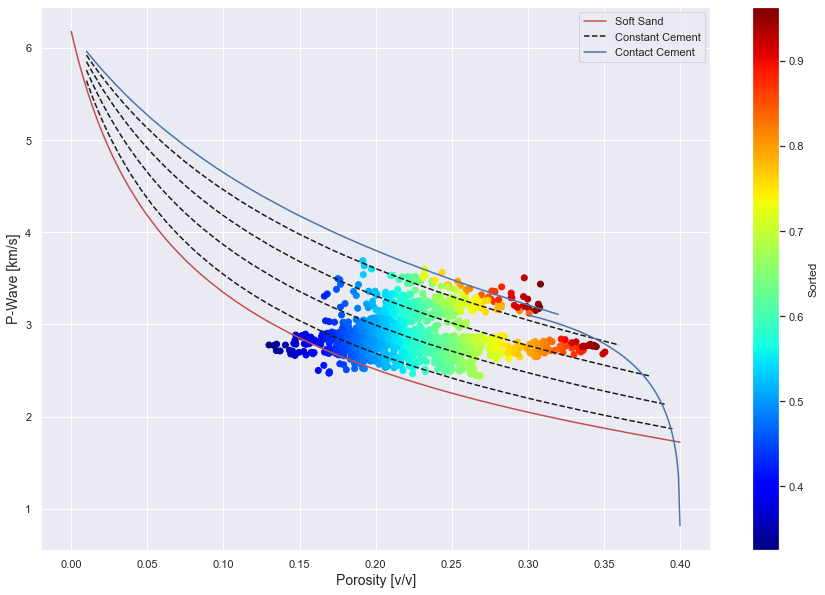

In [31]:
RHO_sh = 2.8
K_sh = 15
MU_sh = 5

phic = 0.4
f = 1

phi = np.arange(0, 0.401, 0.001)
K0, G0, RHO0 = 36, 44, 2.65

Cn = 20-34*phic+14*phic**2

phi_co = porositas(0.3, 0.4)
phi_cons30 = porositas(0.01, 0.30)
phi_cons32 = porositas(0.01, 0.32)
phi_cons34 = porositas(0.01, 0.34)
phi_cons36 = porositas(0.01, 0.36)
phi_cons38 = porositas(0.01, 0.38)
phi_cons39 = porositas(0.01, 0.39)
phi_cons395 = porositas(0.01, 0.395)

# print(phi_cons32)
# 1. Contact-cement

result, M, K_DRY, G_DRY, vp2, vs2 = contactcement(
    K0, G0, phi_co, phic=0.40, Cn=Cn, Kc= K_sh, Gc=MU_sh, scheme=2, rhob=2.65)

phi_bn = [0.3, 0.320, 0.340, 0.360, 0.380, 0.390, 0.395]

M_b = []
K_bc = []
G_bc = []
for phib in phi_bn:
    if phib in result.keys():
        M_b.append(result[phib][0])
        K_bc.append(result[phib][1])
        G_bc.append(result[phib][2])

# 2. Softsand/Friable sand
K_DRYL, G_DRYL, vp1, vs1 = softsand_lower(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1, rhob=rhom)

# 3. Constant-cement
K_DRYS30, G_DRYS30, vps30, vss30 = constancement(
    K_bc[0], G_bc[0], K0, G0, phi_cons30, phi_b=0.30, rhob=rhom, Cn=8.6, rhob_fl=0.2)
# print(K_DRYS30)

K_DRYS32, G_DRYS32, vps32, vss32 = constancement(
    K_bc[1], G_bc[1], K0, G0, phi_cons32, phi_b=0.32, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS34, G_DRYS34, vps34, vss34 = constancement(
    K_bc[2], G_bc[2], K0, G0, phi_cons34, phi_b=0.34, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS36, G_DRYS36, vps36, vss36 = constancement(
    K_bc[3], G_bc[3], K0, G0, phi_cons36, phi_b=0.36, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS38, G_DRYS38, vps38, vss38 = constancement(
    K_bc[4], G_bc[4], K0, G0, phi_cons38, phi_b=0.38, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS39, G_DRYS39, vps39, vss39 = constancement(
    K_bc[5], G_bc[5], K0, G0, phi_cons39, phi_b=0.39, rhob=rhom, Cn=8.6, rhob_fl=0.2)

K_DRYS395, G_DRYS395, vps395, vss395 = constancement(
    K_bc[6], G_bc[6], K0, G0, phi_cons395, phi_b=0.395, rhob=rhom, Cn=8.6, rhob_fl=0.2)

plt.figure(figsize=(15, 10))
plt.plot(phi, vp1, color='r', label='Soft Sand' )
plt.plot(phi_cons32, vps32, color='b' )
# plt.plot(phi_cons30, vps30, color='k', linestyle = '--', label='Constant Cement')
# plt.plot(phi_cons34, vps34, color='k', linestyle = '--')
plt.plot(phi_cons36, vps36, color='k', linestyle = '--', label='Constant Cement')
plt.plot(phi_cons38, vps38, color='k', linestyle = '--')
plt.plot(phi_cons39, vps39, color='k', linestyle = '--')
plt.plot(phi_cons395, vps395, color='k', linestyle = '--')



sort = well['porosity'] / well['porositas_end']
well['sort'] = sort
plt.scatter(well['porosity'], well['p-wave_dry'], c = sort, cmap = 'jet', facecolor='k')
plt.colorbar(label='Sorted')
plt.xlabel('Porosity [v/v]', fontsize=14)
plt.ylabel('P-Wave [km/s]', size=14)
plt.plot(phi_co, vp2, label='Contact Cement', color='b')
plt.legend()
plt.plot()
plt.savefig('sorted.png', dpi=120)
plt.show()

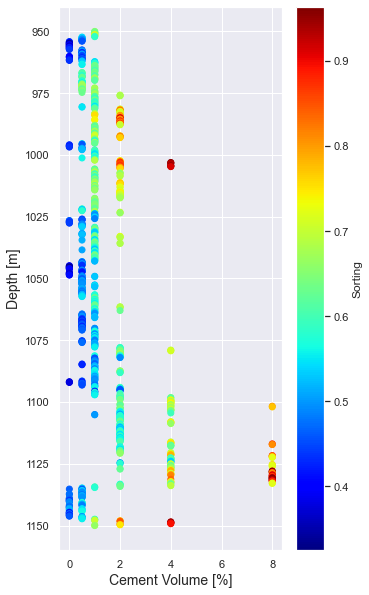

In [32]:
plt.figure(figsize=(5, 10))
plt.scatter(well['cement'], well['depth'], c=well['sort'], cmap='jet')
plt.colorbar(label='Sorting')
plt.xlabel('Cement Volume [%]', size=14)
plt.ylabel('Depth [m]', size=14)
plt.gca().invert_yaxis()
plt.savefig('sorted-2.png', dpi=120)
plt.show()

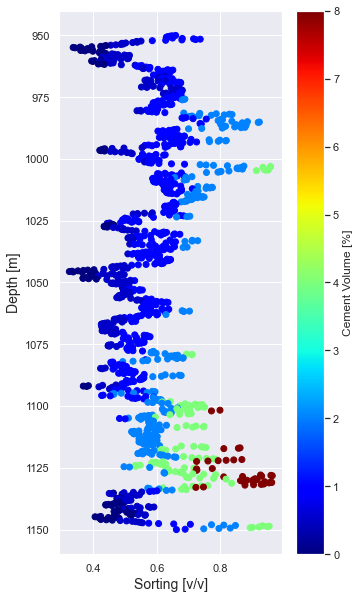

In [33]:
plt.figure(figsize=(5, 10))
plt.scatter(well['sort'], well['depth'], c=well['cement'], cmap='jet')
plt.colorbar(label='Cement Volume [%]')
plt.xlabel('Sorting [v/v]', size=14)
plt.ylabel('Depth [m]', size=14)
plt.gca().invert_yaxis()
plt.savefig('cement-2.png', dpi=120)
plt.show()
